In [1]:
import pandas as pd


In [3]:
#!pip install --upgrade snowflake-connector-python
#import snowflake.connector

import json
import yaml

creds = json.loads(open("snowflake_ds_service.json",'r').read())

ff = open('snowflake_ds_service.yaml', 'w+')
yaml.dump(creds, ff, allow_unicode=True)


In [5]:
#import sys
#sys.path.append('../utils')
from snowflake_db import SnowflakeDB
db = SnowflakeDB('data-science-user', path_to_credentials='snowflake_ds_service.yaml')
cursor = db.get_cursor()

connecting to profile data-science-user
DB Connection Successfull


In [26]:
#sdata = pd.read_csv("sephora_spacial_info.csv")
sdata_q = """select * from dev.taxonomy.sephora_locations"""
res = cursor.execute("""select * from dev.taxonomy.sephora_locations""").fetchall()
sdata = pd.DataFrame.from_records(res, columns=[x[0] for x in cursor.description]).reset_index(drop=True)
#sdata['ID'] = [x for x in range(len(sdata))]
print(sdata.head())
#print(sdata.shape)
#print(sdata.dtypes)
sdata

  RETAILER_BRAND          CITY STATE  LATITUDE  LONGITUDE  \
0        sephora      Portland    OR  45.52345 -122.67621   
1        sephora      Honolulu    HI  21.30694 -157.85833   
2        sephora  Collierville    TN  35.04204  -89.66453   
3        sephora       Houston    TX  29.76328  -95.36327   
4        sephora       Memphis    TN  35.14953  -90.04898   

   RETAIL_LOCATION_COUNT  
0                      5  
1                      2  
2                      1  
3                      9  
4                      2  


RETAILER_BRAND           CITY STATE  LATITUDE  LONGITUDE  \
0          sephora       Portland    OR  45.52345 -122.67621   
1          sephora       Honolulu    HI  21.30694 -157.85833   
2          sephora   Collierville    TN  35.04204  -89.66453   
3          sephora        Houston    TX  29.76328  -95.36327   
4          sephora        Memphis    TN  35.14953  -90.04898   
..             ...            ...   ...       ...        ...   
731        sephora        Madison    WI  43.07305  -89.40123   
732        sephora    Chino Hills    CA  33.99380 -117.75888   
733        sephora       Amarillo    TX  35.22200 -101.83130   
734        sephora  National City    CA  32.67811 -117.09920   
735        sephora     Las Cruces    NM  32.31232 -106.77834   

     RETAIL_LOCATION_COUNT  
0                        5  
1                        2  
2                        1  
3                        9  
4                        2  
..                     ...  
731                      3  
732                      1  
733                      1  
734                      1  
735                      1  

[736 rows x 6 columns]

In [14]:
import pandas as pd

def fetch_pandas_sqlalchemy(sql):
    rows = 0
    for chunk in pd.read_sql_query(sql, engine, chunksize=50000):
        rows += chunk.shape[0]
    print(rows)

In [16]:
fetch_pandas_sqlalchemy('select * from dev.taxonomy.sephora_locations')

NameError: name 'engine' is not defined

In [73]:
sdata.describe()

LATITUDE   LONGITUDE  RETAIL_LOCATION_COUNT
count  736.000000  736.000000             736.000000
mean    37.262157  -92.661551               1.387228
std      5.248487   16.343334               0.912975
min     21.306940 -158.058200               1.000000
25%     33.631702 -102.928015               1.000000
50%     38.275595  -87.956465               1.000000
75%     41.257680  -80.228313               2.000000
max     61.218060  -68.777810               9.000000

In [49]:
import folium
folium.Map()

In [104]:
usa = folium.Map(location= [61.218060, -158.058200], zoom_start = 7)


In [105]:
incidents = folium.map.FeatureGroup()

In [106]:
for lat, lng, in zip(sdata.LATITUDE, sdata.LONGITUDE):
    incidents.add_child(
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    color='yellow',
    fill=True,
    fill_color='blue',
    fill_opacity=0.6))
    

In [107]:
usa.add_child(incidents)

In [108]:
latitudes = list(sdata.LATITUDE)
longitudes = list(sdata.LONGITUDE)

In [52]:
for lat, lng in zip(latitudes, longitudes):
    folium.Marker([lat, lng]).add_to(usa)
usa.add_child(incidents)

In [53]:
import folium
from folium.plugins import MarkerCluster


m = folium.Map(location=[61.218060, -158.058200], zoom_start=5)

marker_cluster = MarkerCluster().add_to(m)


folium.Marker(
    location=[61.218060, -158.058200],
    popup="Add popup text here.",
    icon=folium.Icon(color="green", icon="ok-sign"),
).add_to(marker_cluster)

folium.Marker(
    location=[61.218060, -158.058200],
    popup="Add popup text here.",
    icon=folium.Icon(color="red", icon="remove-sign"),
).add_to(marker_cluster)

folium.Marker(
    location=[61.218060, -158.058200],
    popup="Add popup text here.",
    icon=None,
).add_to(marker_cluster)

m

In [68]:
lons = np.array(sdata.LONGITUDE)
lats = np.array(sdata.LATITUDE)

locations = list(zip(lats, lons))
popups = ["lon:{}<br>lat:{}".format(lon, lat) for (lat, lon) in locations]


In [69]:
icon_create_function = """\
function(cluster) {
    return L.divIcon({
    html: '<b>' + cluster.getChildCount() + '</b>',
    className: 'marker-cluster marker-cluster-large',
    iconSize: new L.Point(20, 20)
    });
}"""


In [70]:
from folium.plugins import MarkerCluster

m = folium.Map(
    location=[np.mean(lats), np.mean(lons)], tiles="Cartodb Positron", zoom_start=1
)

marker_cluster = MarkerCluster(
    locations=locations,
    popups=popups,
    name="1000 clustered icons",
    overlay=True,
    control=True,
    icon_create_function=icon_create_function,
)

marker_cluster.add_to(m)

folium.LayerControl().add_to(m)

m


In [71]:
%%time

m = folium.Map(
    location=[np.mean(lats), np.mean(lons)],
    tiles='Cartodb Positron',
    zoom_start=1
)

marker_cluster = MarkerCluster(
    name='1000 clustered icons',
    overlay=True,
    control=False,
    icon_create_function=None
)

for k in range(size):
    location = lats[k], lons[k]
    marker = folium.Marker(location=location)
    popup = 'lon:{}<br>lat:{}'.format(location[1], location[0])
    folium.Popup(popup).add_to(marker)
    marker_cluster.add_child(marker)

marker_cluster.add_to(m)

folium.LayerControl().add_to(m)


CPU times: user 12.6 ms, sys: 4.12 ms, total: 16.7 ms
Wall time: 16.4 ms


In [72]:
m


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv

In [76]:
sdata.dropna(axis=0,how='any',subset=['LATITUDE','LONGITUDE'],inplace=True)

In [86]:
# Variable with the Longitude and Latitude
X = sdata.loc[:,['ID','LATITUDE','LONGITUDE']]
X.head(10)

ID  LATITUDE  LONGITUDE
0   0  41.06022 -111.97105
1   1  41.13998 -104.82025
2   2  46.55735 -120.47506
3   3  33.92044  -80.34147
4   4  26.15952  -97.99084
5   5  38.88101  -77.10428
6   6  35.20453  -89.87398
7   7  32.94124  -97.13418
8   8  41.52364  -90.57764
9   9  32.54208  -97.32085

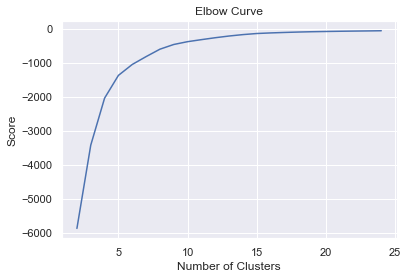

In [87]:
K_clusters = range(2,25)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = sdata[['LATITUDE']]
X_axis = sdata[['LONGITUDE']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [94]:
from sklearn.metrics import silhouette_score

#Silhouette Analysis
for n_cluster in range(2, 25):
    kmeans = KMeans(n_clusters=n_cluster).fit(sdata.iloc[:,[3,4]])
    label = kmeans.labels_
    sil_coeff = silhouette_score(sdata.iloc[:,[3,4]], label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    

For n_clusters=2, The Silhouette Coefficient is 0.6359344414712784
For n_clusters=3, The Silhouette Coefficient is 0.48370647421287194
For n_clusters=4, The Silhouette Coefficient is 0.4585055160785701
For n_clusters=5, The Silhouette Coefficient is 0.5244313043474236
For n_clusters=6, The Silhouette Coefficient is 0.4992850505376732
For n_clusters=7, The Silhouette Coefficient is 0.5270610690260016
For n_clusters=8, The Silhouette Coefficient is 0.5230594673675746
For n_clusters=9, The Silhouette Coefficient is 0.50988433873297
For n_clusters=10, The Silhouette Coefficient is 0.4934627225899465
For n_clusters=11, The Silhouette Coefficient is 0.4938630691645028
For n_clusters=12, The Silhouette Coefficient is 0.4982545707318111
For n_clusters=13, The Silhouette Coefficient is 0.5019321173292539
For n_clusters=14, The Silhouette Coefficient is 0.4909475749961825
For n_clusters=15, The Silhouette Coefficient is 0.48829107099335034
For n_clusters=16, The Silhouette Coefficient is 0.50088

In [96]:
kmeans = KMeans(n_clusters = 18, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(10)

ID  LATITUDE  LONGITUDE  cluster_label
0   0  41.06022 -111.97105              7
1   1  41.13998 -104.82025             12
2   2  46.55735 -120.47506             11
3   3  33.92044  -80.34147              5
4   4  26.15952  -97.99084              0
5   5  38.88101  -77.10428              1
6   6  35.20453  -89.87398             16
7   7  32.94124  -97.13418              0
8   8  41.52364  -90.57764              9
9   9  32.54208  -97.32085              0

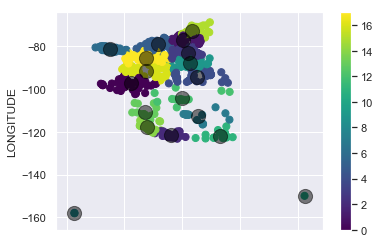

In [98]:
X.plot.scatter(x = 'LATITUDE', y = 'LONGITUDE', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

Index(['LATITUDE', 'LONGITUDE'], dtype='object')

In [99]:
X = X[['ID','cluster_label']]
X.head(5)

ID  cluster_label
0   0              7
1   1             12
2   2             11
3   3              5
4   4              0

In [100]:
clustered_data = sdata.merge(X, left_on='ID', right_on='ID')
clustered_data.head(5)

RETAILER_BRAND       CITY STATE  LATITUDE  LONGITUDE  RETAIL_LOCATION_COUNT  \
0        sephora     Layton    UT  41.06022 -111.97105                      1   
1        sephora   Cheyenne    WY  41.13998 -104.82025                      1   
2        sephora  Union Gap    WA  46.55735 -120.47506                      1   
3        sephora     Sumter    SC  33.92044  -80.34147                      1   
4        sephora    Weslaco    TX  26.15952  -97.99084                      1   

   ID  cluster_label  
0   0              7  
1   1             12  
2   2             11  
3   3              5  
4   4              0

In [ ]:
clustered_data.to_csv ('clustered_data.csv', index=None, header = True)

In [101]:
centers = kmeans.cluster_centers_
print(centers)

[[  31.06242104  -97.31034627]
 [  40.12291597  -77.17446746]
 [  38.02675814 -121.6345786 ]
 [  40.93469456  -83.03933596]
 [  42.59786297  -94.14284919]
 [  35.74612559  -79.09766147]
 [  27.438132    -81.1620538 ]
 [  42.76925625 -112.80509312]
 [  21.321245   -157.958265  ]
 [  41.44038194  -88.0183579 ]
 [  61.21806    -149.90028   ]
 [  46.49900632 -121.82190316]
 [  40.03710095 -104.38235571]
 [  33.48748944 -110.922155  ]
 [  33.97089191 -117.82887471]
 [  41.66584145  -72.92349831]
 [  33.79484073  -91.56134683]
 [  33.7064948   -85.2814244 ]]


In [109]:
occurences = folium.map.FeatureGroup()
n_mean = clustered_data['RETAIL_LOCATION_COUNT'].mean()

for lat, lng, number, city, state in zip(clustered_data['LATITUDE'],
                                         clustered_data['LONGITUDE'],
                                         clustered_data['RETAIL_LOCATION_COUNT'],
                                         clustered_data['CITY'],
                                         clustered_data['STATE'],):
    occurences.add_child(
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=number/n_mean*5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            tooltip = str(number)+','+str(city) +','+ str(state)
        )
    )

usa.add_child(occurences)

In [122]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[61.218060, -158.058200], zoom_start=4)

# set color scheme for the clusters
x = np.arange(17)
ys = [i + x + (i*x)**2 for i in range(17)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, cluster, city, state in zip(clustered_data['LATITUDE'], clustered_data['LONGITUDE'],  
                                            clustered_data['cluster_label'],
                                         clustered_data['CITY'],
                                         clustered_data['STATE']):
    #label = folium.Popup(str(city)+ ','+str(state) + '- Cluster ' + str(cluster), parse_html=True)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        tooltip = str(city)+ ','+str(state) + '- Cluster ' + str(cluster),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

In [119]:
rainbow[17-1]

IndexError: list index out of range

In [121]:
clustered_data['cluster_label'].dtype


dtype('int32')

In [123]:
clustered_data[['LATITUDE', 'LONGITUDE']].values

array([[  41.06022, -111.97105],
       [  41.13998, -104.82025],
       [  46.55735, -120.47506],
       ...,
       [  45.78329, -108.50069],
       [  34.42083, -119.69819],
       [  32.79477, -116.96253]])

In [126]:
import scipy
## find real centroids
closest, distances = scipy.cluster.vq.vq(kmeans.cluster_centers_, clustered_data[['LATITUDE', 'LONGITUDE']].values)

clustered_data["centroids"] = 0
for i in closest:
    clustered_data["centroids"].iloc[i] = 1

print(clustered_data.head())


  RETAILER_BRAND       CITY STATE  LATITUDE  LONGITUDE  RETAIL_LOCATION_COUNT  \
0        sephora     Layton    UT  41.06022 -111.97105                      1   
1        sephora   Cheyenne    WY  41.13998 -104.82025                      1   
2        sephora  Union Gap    WA  46.55735 -120.47506                      1   
3        sephora     Sumter    SC  33.92044  -80.34147                      1   
4        sephora    Weslaco    TX  26.15952  -97.99084                      1   

   ID  cluster_label  centroids  
0   0              7          0  
1   1             12          0  
2   2             11          0  
3   3              5          0  
4   4              0          0  


In [130]:
from sklearn import preprocessing, cluster

x, y = "LATITUDE", "LONGITUDE"
color = "cluster_label"
size = "RETAIL_LOCATION_COUNT"
popup = "CITY"
marker = "centroids"

data = clustered_data.copy()

## create color column
lst_elements = sorted(list(clustered_data[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)

## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))

## add centroids marker
lst_elements = sorted(list(clustered_data[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row[x],row[y]], 
           popup=row[marker], draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)

## plot the map
map_

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
